In [35]:
# 1. Import thư viện cần thiết 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint #Lưu lại mô hình huấn luyện tốt nhất
from tensorflow.keras.models import load_model #Load models



In [36]:
# 2. Đọc file csv  
df = pd.read_csv('GVR.csv')
# Định dạng cấu trúc thời gian
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
# Sort the dataframe by date in ascending order
df = df.sort_values('Ngày') 
df1=df.reset_index()['Lần cuối']

In [37]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [38]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [39]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [40]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1] , 1)

In [42]:
# 8. Define LSTM Model
model = Sequential()

# CNN layers

model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2))) 
model.add(TimeDistributed(Flatten()))

# LSTM layers
model.add(LSTM(100))   
#Final layers
model.add(Dense(1, activation='linear'))
 
model.compile(loss='mean_squared_error',optimizer='adam')



In [43]:
# 9. Fit mô hình với dữ liệu train
save_model="my_model.hdf5"

best_model=ModelCheckpoint(save_model, monitor='loss', verbose=1, save_best_only= True, mode='auto')

model.fit(X_train, y_train, validation_data=(X_test,ytest), epochs=100,batch_size=64, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04029, saving model to my_model.hdf5
13/13 - 4s - loss: 0.0403 - val_loss: 0.0244 - 4s/epoch - 316ms/step
Epoch 2/100

Epoch 2: loss improved from 0.04029 to 0.01321, saving model to my_model.hdf5
13/13 - 0s - loss: 0.0132 - val_loss: 0.0596 - 126ms/epoch - 10ms/step
Epoch 3/100

Epoch 3: loss improved from 0.01321 to 0.00752, saving model to my_model.hdf5
13/13 - 0s - loss: 0.0075 - val_loss: 0.0254 - 132ms/epoch - 10ms/step
Epoch 4/100

Epoch 4: loss improved from 0.00752 to 0.00483, saving model to my_model.hdf5
13/13 - 0s - loss: 0.0048 - val_loss: 0.0171 - 133ms/epoch - 10ms/step
Epoch 5/100

Epoch 5: loss improved from 0.00483 to 0.00407, saving model to my_model.hdf5
13/13 - 0s - loss: 0.0041 - val_loss: 0.0254 - 125ms/epoch - 10ms/step
Epoch 6/100

Epoch 6: loss improved from 0.00407 to 0.00323, saving model to my_model.hdf5
13/13 - 0s - loss: 0.0032 - val_loss: 0.0137 - 128ms/epoch - 10ms/step
Epoch 7/100

Epoch 7: loss improve

In [44]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 17ms/step


In [45]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [46]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 15397.349406628147
Testing RMSE: 27470.700357565063


In [47]:
# 13. Dự báo 30 ngày tiếp theo
# Dùng 100 giá trị cuối cùng của bộ dữ liệu để dự đoán giá trị ngày tiếp theo

x_input=df1[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, 1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.25888148]
101
1 day input [0.2573667  0.22667212 0.21059401 0.23105706 0.24128859 0.23398036
 0.23982694 0.25444341 0.2573667  0.26321328 0.24859682 0.21936389
 0.2164406  0.22521048 0.22082554 0.19159261 0.21790225 0.2164406
 0.20474743 0.20474743 0.22813377 0.235442   0.23690365 0.22228718
 0.22228718 0.22228718 0.22521048 0.23398036 0.22667212 0.24567353
 0.26175164 0.26905987 0.27782975 0.29390786 0.28367633 0.28952292
 0.25590505 0.24713517 0.25152011 0.2573667  0.23398036 0.23251871
 0.23836529 0.22959542 0.21059401 0.21497895 0.22521048 0.23251871
 0.23105706 0.25298176 0.25005847 0.22667212 0.23398036 0.21936389
 0.20913237 0.20913237 0.22228718 0.21790225 0.21351731 0.2164406
 0.22228718 0.22521048 0.24421188 0.23982694 0.23836529 0.21936389
 0.24567353 0.235442   0.23690365 0.22082554 0.22374883 0.22521048
 0.22521048 0.23398036 0.23690365 0.23398036 0.23251871 0.23105706
 0.25444341 0.26759822 0.26759822 0.27490645 0.2573667  0.26613658
 0.26613658 0.2763681  0.27929139 0

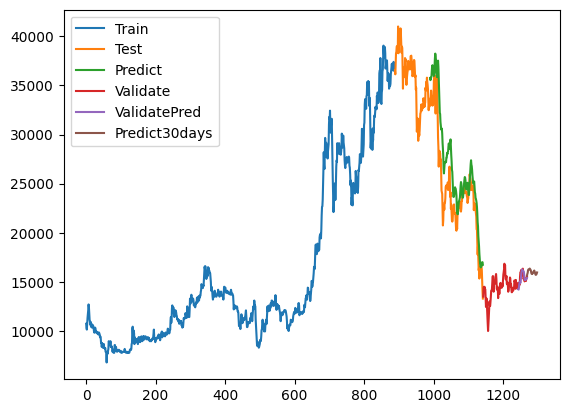

In [48]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()